In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
# can alternatively use addfiles to spark init in nb_spark
from src import EDA, ModelEvaluation, Preprocess, Split
%load_ext autoreload
%autoreload 2

spark_session = SparkSession.builder.getOrCreate()

In [2]:
def get_random_scores(n, max_score):
    return np.random.random_sample(n, ) * max_score

def create_dataset(df, min_games_played=0, min_users_for_game=0):
    df = EDA.get_filtered_user_item(df, min_games_played=min_games_played, min_users_for_game=min_users_for_game)
    pandas_train_test = Split.PandasTrainTest(df, seed=1)
    k_fold_dfs = pandas_train_test.get_k_folds(5, game_split_train=.3)
    print('first train test split size: {}, {} '.format(k_fold_dfs[0][0].shape[0], k_fold_dfs[0][1].shape[0]))
    sparkified_k_fold_dfs = [(spark_session.createDataFrame(a), spark_session.createDataFrame(b)) for a, b in k_fold_dfs]
    return sparkified_k_fold_dfs

In [3]:
# we leave more than the top sorted by prediction because the actual may be n away from the 
# top predictions
def sort_predictions_slice(arr, n):
    actual_and_pred = np.array(arr)
    # sort by predictions
    indeces = np.argsort(actual_and_pred[:, 1])
    return actual_and_pred[indeces[::-1]][:n].tolist()

def dcg_at_k(scores, k):
    """
    Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float
    """
    r = np.asfarray(scores)[:k]
    if r.size:
        # item 1 and 2 have same weights
        # return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        # use below for more emphasis on first rank
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(scores, k):
    """
    Normalized Discounted cumulative gain
    See http://fastml.com/evaluating-recommender-systems/
    Args:
        r: List - Relevance scores in rank order
        k: Number of results to consider
    Returns:
        Float from 0 to 1
    """
    dcg_max = dcg_at_k(sorted(scores, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(scores, k) / dcg_max

def get_rdd_ndcg(rdd, top_n=3, label_col='playtime_min_max', prediction_col='prediction', id_col='uid'):
    rdd_ndcg = rdd.map(lambda row: (row[id_col], [(row[label_col], row[prediction_col])])) \
        .reduceByKey(lambda total, val: total + val) \
        .map(lambda kv: (kv[0], sort_predictions_slice(kv[1], 1000))) \
        .map(lambda kv: ndcg_at_k(np.array(kv[1])[:, 0], top_n)) \
        .sum()
    return rdd_ndcg

def fit_and_calculate_kfold_ndcg(model, train_test_dfs, top_n=5):
    results = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        predictions_rdd = predictions.rdd
        ndcg = get_rdd_ndcg(predictions_rdd, top_n=top_n, prediction_col='prediction')
        # can divide ndcg by user count - would be more efficient to pass counts
        num_users = len(predictions.groupby('uid').count().collect())
        results.append(ndcg / num_users)
    return sum(results) / len(results)

def fit_and_predict_kfold(model, train_test_dfs):
    prediction_rdds = []
    for train, test in train_test_dfs:
        fitted_model = model.fit(train)
        predictions = fitted_model.transform(test)
        prediction_rdd = predictions.rdd
        prediction_rdds.append(prediction_rdd)
    return prediction_rdds

def get_ndcg_and_random_ndcg(dataset):
    '''
        Returns a tuple with the average ndcg over k folds
        and the average random ndcg of the same k folds
    '''
    k_fold_prediction_rdds = fit_and_predict_kfold(als_model, dataset)
    ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
    random_ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='random_prediction') for predictions_rdd in k_fold_prediction_rdds]
    ndcg = sum(ndcgs) / len(ndcgs)
    random_ndcg = sum(random_ndcgs) / len(random_ndcgs)
    print('ndcg: ', ndcg)
    return (ndcg, random_ndcg)

In [4]:
# need holdout users.  Hold out 10%.
steam_df = EDA.load_200k()
preprocessor = Preprocess.PandasALSPreprocessor(steam_df)
preprocessor.add_item_ids()
preprocessor.add_rank_buckets()
preprocessor.add_min_max()
preprocessor.keep_standard_columns()
steam_df = preprocessor.get_df()
max_score = steam_df['playtime_min_max'].max()
steam_df['random_prediction'] = get_random_scores(steam_df.shape[0], max_score)
pandas_train_test = Split.PandasTrainTest(steam_df, seed=1)
train_val, holdout_test = pandas_train_test.user_only_split(user_split_train=.9)
print('split sizes: ', (train_val.shape[0], holdout_test.shape[0]))
train_val.head(2)

split sizes:  (62791, 7698)


,uid,playtime,playtime_min_max,game_name,game_uid,random_prediction
1,151603712,273.0,0.412256,The Elder Scrolls V Skyrim,0,0.259380
3,151603712,87.0,0.414122,Fallout 4,1,0.022195


In [5]:
als_model = ALS(
    itemCol='game_uid',
    userCol='uid',
    ratingCol='playtime_min_max',
    nonnegative=True,    
    regParam=0.1,
    coldStartStrategy="drop", # Drops if user or item in test was not in train
    rank=10
);

In [17]:
base_case = create_dataset(train_val, min_games_played=0, min_users_for_game=0)
get_ndcg_and_random_ndcg(base_case)

Number of users:  10215
first train test split size 53164, 9627: 
ndcg:  431.024559748
random_ndcg:  365.709611512


(431.02455974834868, 365.70961151170661)

## Cold Start for Users

In [6]:
min_games_played_datasets1 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0) for i in range(1,10)]

Number of users:  10215
first train test split size: 53164, 9627 
Number of users:  4316
first train test split size: 48882, 8008 
Number of users:  3123
first train test split size: 46142, 8234 
Number of users:  2553
first train test split size: 45786, 6940 
Number of users:  2199
first train test split size: 44504, 6876 
Number of users:  1925
first train test split size: 43069, 6941 
Number of users:  1718
first train test split size: 41888, 6698 
Number of users:  1575
first train test split size: 41363, 6404 
Number of users:  1459
first train test split size: 39763, 7076 


In [16]:
# prediction vs random_prediction ndcg
user_results1 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_games_played_datasets1]
user_increase1 = [((predicted / random) - 1) * 100 for predicted, random in user_results1]

ndcg:  431.024559748
ndcg:  426.150640534
ndcg:  427.690077312
ndcg:  325.154006477
ndcg:  263.827389752
ndcg:  219.223411865
ndcg:  186.867872024
ndcg:  163.929897318
ndcg:  147.792840053


In [17]:
min_games_played_datasets2 = [create_dataset(train_val, min_games_played=i, min_users_for_game=0) for i in range(10,20)]

first train test split size: 38833, 6926 
first train test split size: 38194, 6564 
first train test split size: 37895, 5936 
first train test split size: 37177, 5922 
first train test split size: 36543, 5431 
first train test split size: 35763, 5520 
first train test split size: 34761, 5472 
first train test split size: 33951, 5352 
first train test split size: 32919, 5665 
first train test split size: 31899, 5829 


In [18]:
# prediction vs random_prediction ndcg
user_results2 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_games_played_datasets2]
user_increase2 = [((predicted / random) - 1) * 100 for predicted, random in user_results2]

ndcg:  129.388139867
ndcg:  116.755643929
ndcg:  104.787068903
ndcg:  99.0230179735
ndcg:  90.6627332092
ndcg:  84.0846961125
ndcg:  73.6182060266
ndcg:  68.3411702537
ndcg:  64.5049908406
ndcg:  59.4235650916


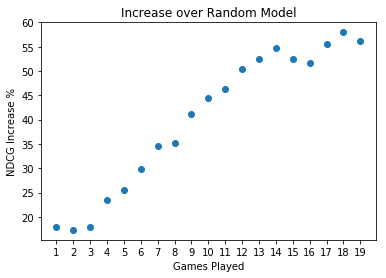

In [32]:
user_increases = user_increase1 + user_increase2
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), user_increases)
ax.set_xticks(list(range(1,20)))
ax.set_title('Increase over Random Model')
ax.set_xlabel('Games Played')
ax.set_ylabel('NDCG Increase %')
fig.show()
# fig.savefig('../figures/increase_games_played.png')

## Cold Start for Items

In [6]:
min_user_counts_datasets1 = [create_dataset(train_val, min_games_played=1, min_users_for_game=i) for i in range(1,10)]

first train test split size: 53282, 8503 
first train test split size: 51985, 8811 
first train test split size: 50415, 9472 
first train test split size: 50348, 8755 
first train test split size: 48980, 9268 
first train test split size: 48960, 8686 
first train test split size: 48168, 8773 
first train test split size: 48172, 8069 
first train test split size: 47158, 8475 


In [7]:
# prediction vs random_prediction ndcg
item_results1 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_user_counts_datasets1]
item_increase1 = [((predicted / random) - 1) * 100 for predicted, random in item_results1]

ndcg:  424.365635435
ndcg:  428.062593462
ndcg:  430.009713229
ndcg:  430.345438786
ndcg:  428.701882087
ndcg:  429.589627781
ndcg:  425.438680142
ndcg:  427.026674432
ndcg:  425.326833497


In [8]:
min_user_counts_datasets2 = [create_dataset(train_val, min_games_played=1, min_users_for_game=i) for i in range(10,20)]

first train test split size: 46900, 8153 
first train test split size: 45940, 8420 
first train test split size: 45850, 7910 
first train test split size: 45183, 7895 
first train test split size: 44633, 7960 
first train test split size: 44311, 7892 
first train test split size: 44245, 7605 
first train test split size: 43222, 8135 
first train test split size: 42980, 8017 
first train test split size: 43512, 7067 


In [9]:
# prediction vs random_prediction ndcg
item_results2 = [get_ndcg_and_random_ndcg(dataset) for dataset in min_user_counts_datasets2]
item_increase2 = [((predicted / random) - 1) * 100 for predicted, random in item_results2]

ndcg:  424.746366028
ndcg:  423.683711599
ndcg:  423.298176092
ndcg:  423.153155444
ndcg:  423.386130051
ndcg:  420.159857847
ndcg:  420.405357366
ndcg:  420.793073089
ndcg:  421.669817998
ndcg:  419.979141982


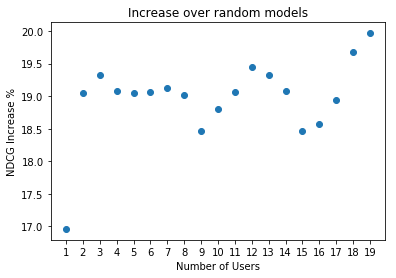

In [11]:
item_increases = item_increase1 + item_increase2
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), item_increases)
ax.set_title('Increase over random models')
ax.set_xlabel('Number of Users')
ax.set_ylabel('NDCG Increase %')
ax.set_xticks(list(range(1,20)))
fig.show()
# fig.savefig('../figures/increase_users_for_items2.png')

## 5 Games Played+ As Baseline

In [22]:
optimal_games_n_users_datasets = [create_dataset(train_val, min_games_played=5, min_users_for_game=i) for i in range(1,20)]

Number of users:  2199
first train test split size: 43706, 6720 
Number of users:  2198
first train test split size: 42512, 6994 
Number of users:  2198
first train test split size: 41763, 6865 
Number of users:  2198
first train test split size: 41142, 6743 
Number of users:  2198
first train test split size: 40482, 6608 
Number of users:  2198
first train test split size: 39991, 6528 
Number of users:  2198
first train test split size: 39433, 6446 
Number of users:  2198
first train test split size: 38893, 6347 
Number of users:  2198
first train test split size: 38406, 6261 
Number of users:  2198
first train test split size: 37939, 6185 
Number of users:  2198
first train test split size: 37408, 6082 
Number of users:  2198
first train test split size: 36921, 6002 
Number of users:  2198
first train test split size: 36386, 5908 
Number of users:  2198
first train test split size: 35998, 5843 
Number of users:  2197
first train test split size: 35620, 5897 
Number of users:  2196
fi

In [23]:
results_optimal_games_n_users = [get_ndcg_and_random_ndcg(dataset) for dataset in optimal_games_n_users_datasets]
optimal_games_item_increase = [((predicted / random) - 1) * 100 for predicted, random in results_optimal_games_n_users]

ndcg:  264.516087887
random_ndcg:  208.011943613
ndcg:  269.762861809
random_ndcg:  208.97919148
ndcg:  273.107463907
random_ndcg:  209.835322161
ndcg:  273.617186165
random_ndcg:  209.285715376
ndcg:  276.940748499
random_ndcg:  212.541227677
ndcg:  279.111205521
random_ndcg:  214.215815606
ndcg:  279.948323427
random_ndcg:  213.27856396
ndcg:  280.754779383
random_ndcg:  213.190169748
ndcg:  281.660680602
random_ndcg:  216.90452359
ndcg:  283.539577328
random_ndcg:  216.337465577
ndcg:  284.364401041
random_ndcg:  217.597094961
ndcg:  282.56483939
random_ndcg:  218.459782742
ndcg:  282.599872221
random_ndcg:  220.153996636
ndcg:  284.496373296
random_ndcg:  221.963798117
ndcg:  285.567029903
random_ndcg:  220.628504139
ndcg:  282.740969176
random_ndcg:  220.85718535
ndcg:  284.772344336
random_ndcg:  221.914168751
ndcg:  286.581516329
random_ndcg:  224.057556309
ndcg:  288.275414858
random_ndcg:  224.990878356


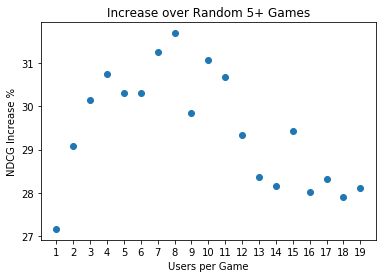

In [27]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), optimal_games_item_increase)
ax.set_title('Increase over Random 5+ Games')
ax.set_xlabel('Users per Game')
ax.set_ylabel('NDCG Increase %')
ax.set_xticks(list(range(1,20)))
fig.show()
# fig.savefig('../figures/increase_users_for_items_at_5.png')

## Final Model

In [28]:
final_model_dataset = create_dataset(train_val, min_games_played=5, min_users_for_game=3)
k_fold_prediction_rdds = fit_and_predict_kfold(als_model, final_model_dataset)
ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='prediction') for predictions_rdd in k_fold_prediction_rdds]
random_ndcgs = [get_rdd_ndcg(predictions_rdd, top_n=5, prediction_col='random_prediction') for predictions_rdd in k_fold_prediction_rdds]
ndcg = sum(ndcgs) / len(ndcgs)
random_ndcg = sum(random_ndcgs) / len(random_ndcgs)
final_model_results = (ndcg, random_ndcg)
final_model_results

Number of users:  2198
first train test split size: 41763, 6865 


(273.10746390662069, 209.83532216054897)

In [29]:
final_increase = ((final_model_results[0] / final_model_results[1]) - 1) * 100
print('Final Model Validation Increase: {}%'.format(round(final_increase, 3)))

Final Model Increase: 30.153%


In [21]:
print('Using {}% of Original Users'.format(round((2198 / 11350) * 100, 2)))

Using 19.37% of Original Users


#### Test on Holdout Validation

In [49]:
final_model_training = EDA.get_filtered_user_item(train_val, min_games_played=5, min_users_for_game=3)
final_model_holdout = EDA.get_filtered_user_item(holdout_test, min_games_played=5, min_users_for_game=3)
final_splitter = Split.PandasTrainTest(final_model_holdout)
holdout_train_games, holdout_test_games  = final_splitter.user_games_split(final_model_holdout, game_split_train=.3)
final_model_training = final_model_training.append(holdout_train_games)

In [54]:
final_model_training_spark_dataset = spark_session.createDataFrame(final_model_training)
holdout_test_spark_dataset = spark_session.createDataFrame(holdout_test_games)
training_fitted_model = als_model.fit(final_model_training_spark_dataset)
final_test_predictions = training_fitted_model.transform(holdout_test_spark_dataset)
final_test_predictions_rdd = final_test_predictions.rdd
# How valuable is this kind of validation here?
# How would we implement it?
final_test_ndcg = get_rdd_ndcg(final_test_predictions_rdd, top_n=5, prediction_col='prediction')
final_test_random_ndcg = get_rdd_ndcg(final_test_predictions_rdd, top_n=5, prediction_col='random_prediction')

In [55]:
final_test_increase = ((final_test_ndcg / final_test_random_ndcg) - 1) * 100
print('Final Model Validation Increase: {}%'.format(round(final_test_increase, 3)))

Final Model Validation Increase: 34.193%


In [57]:
evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_min_max") \
    .setPredictionCol("prediction")
rmse = evaluator.evaluate(final_test_predictions)
random_evaluator = RegressionEvaluator() \
    .setMetricName("rmse") \
    .setLabelCol("playtime_min_max") \
    .setPredictionCol("random_prediction")
random_rmse = random_evaluator.evaluate(final_test_predictions)

In [63]:
final_test_rmse_increase = ((random_rmse / rmse) - 1) * 100
print('Final Model Random RMSE Increase: {}%'.format(round(final_test_rmse_increase, 3)))

Final Model Random RMSE Increase: 222.554%


## We could look at absolute NDCG increases / decreases.. 
But it can be very misleading

In [32]:
raw_increase_ndcg = np.array(results_optimal_games_n_users)[:,0]

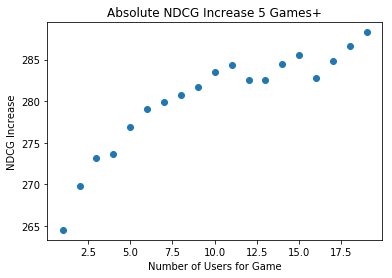

In [35]:
### Even without dividing by data size, absolute NDCG will increase 
### as number of games decreases - Because we are recommending games to users
### and removing possibilities to get wrong
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), raw_increase_ndcg)
ax.set_title('Absolute NDCG Increase 5 Games+')
ax.set_xlabel('Number of Users for Game')
ax.set_ylabel('NDCG Increase')
fig.show()
# fig.savefig('../figures/absolute_optimal_games_n_users_increases.png')

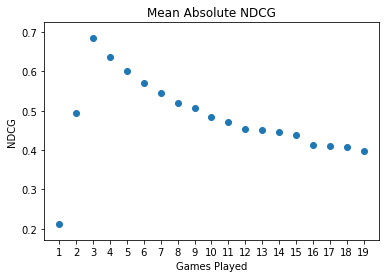

In [63]:
'''
This is expected because Users with low games played
are easier to order perfectly.
The 1 and 2 cutoffs are just issues with splitting the game data for 1 or 2 items into train and test at 30%
'''
all_games_played_datasets = min_games_played_datasets1 + min_games_played_datasets2
user_counts_at_games_played = [len(dset_pair[0][1].groupby('uid').count().collect()) for dset_pair in all_games_played_datasets]
print('Users included in Test split: {}'.format(user_counts_at_games_played))
user_results = user_results1 + user_results2
absolute_increase = np.array(user_results)[:,0]
absolute_normalized_increase = absolute_increase / np.array(user_counts_at_games_played)
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), absolute_normalized_increase)
ax.set_xticks(list(range(1,20)))
ax.set_title('Mean Absolute NDCG')
ax.set_xlabel('Games Played')
ax.set_ylabel('NDCG')
fig.show()
# fig.savefig('../figures/absolute_games_played.png')

Users included in Test split: [2038, 2035, 2031, 2028, 2023, 2021, 2017, 2012, 2010, 2007, 2003, 2001, 1997, 1994, 1992, 1991, 1990, 1987, 1985]


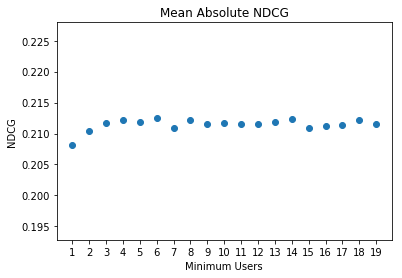

In [13]:
'''
This is somewhat expected because removing Items makes it easier to get a good order of items
The 1 and 2 cutoffs are just issues with splitting the game data for 1 or 2 items into train and test at 30%
'''
all_user_counts_datasets = min_user_counts_datasets1 + min_user_counts_datasets2
user_counts_at_user_cutoffs = [len(dset_pair[0][1].groupby('uid').count().collect()) for dset_pair in all_user_counts_datasets]
print('Users included in Test split: {}'.format(user_counts_at_user_cutoffs))
item_results = item_results1 + item_results2

absolute_increase = np.array(item_results)[:,0]
absolute_normalized_increase = absolute_increase / np.array(user_counts_at_user_cutoffs)
fig, ax = plt.subplots()
ax.scatter(list(range(1,20)), absolute_normalized_increase)
ax.set_xticks(list(range(1,20)))
ax.set_title('Mean Absolute NDCG')
ax.set_xlabel('Minimum Users')
ax.set_ylabel('NDCG')
fig.show()
# fig.savefig('../figures/absolute_user_cutoffs.png')